In [1]:
import math

import torch
import botorch
import gpytorch
import gpytorch.means as means
import gpytorch.kernels as kernels
import gpytorch.likelihoods as likelihoods
from gpytorch.distributions import MultivariateNormal
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers.default = "png"



In [2]:
SAMPLE_KERNELS = [kernels.RBFKernel(), kernels.CosineKernel(), kernels.LinearKernel(),
                  kernels.MaternKernel(), kernels.PeriodicKernel(), kernels.PiecewisePolynomialKernel(),
                  kernels.PolynomialKernel(power=4), kernels.RQKernel(),
                  kernels.SpectralDeltaKernel(num_dims=1), kernels.SpectralMixtureKernel(num_mixtures=2),
                  ]
SAMPLE_LINELIHOODS = [likelihoods.GaussianLikelihood, likelihoods.BernoulliLikelihood, likelihoods.BetaLikelihood,
                      likelihoods.LaplaceLikelihood, likelihoods.StudentTLikelihood]
NUM_SAMPLES = 100
X = torch.linspace(-math.pi, math.pi, NUM_SAMPLES)                  

In [3]:
def create_1d_multivaridate_normal(x, kernel, **kernel_args):
    mean_module = means.ZeroMean()
    mean = mean_module(x)    
    covariance_matrix = kernel(x.view(-1, 1), **kernel_args)
    if "diag" in kernel_args.keys():
        covariance_matrix = torch.diag(covariance_matrix)
    dist = MultivariateNormal(mean, covariance_matrix)
    return x, dist.sample()

def plot(fig, x, y, name, row, col):
    fig.add_trace(go.Scatter(x=x, y=y, mode="lines+markers", name=name), row, col)
    return fig

def plot_2d(fig, matrix, name, row, col):
    fig.add_trace(go.Heatmap(z=np.flipud(matrix.numpy()), name=name), row=row, col=col)
    return fig

In [4]:
def plot_kernel(fig, x, k, row, col, **kernel_args):
    x, y = create_1d_multivaridate_normal(x, k, **kernel_args)
    fig = plot(fig, x, y, k.__class__.__name__, row, col)
    return fig

def plot_covariance(fig, x, kernel, row, col):
    covariance_matrix = kernel(x.view(-1, 1))
    plot_2d(fig, covariance_matrix, kernel.__class__.__name__, row, col)
    return fig

In [5]:
def run_vairous_kernels(x, sample_kernels, scaled=False):
    fig = make_subplots(rows=3, cols=4)
    for idx, k in enumerate(sample_kernels):           
        row = idx // 4 + 1
        col = idx % 4 + 1
        if scaled:
            scaled_k = kernels.ScaleKernel(k)
            plot_kernel(fig, x, scaled_k, row, col)
        else:
            plot_kernel(fig, x, k, row, col)
    fig.show()

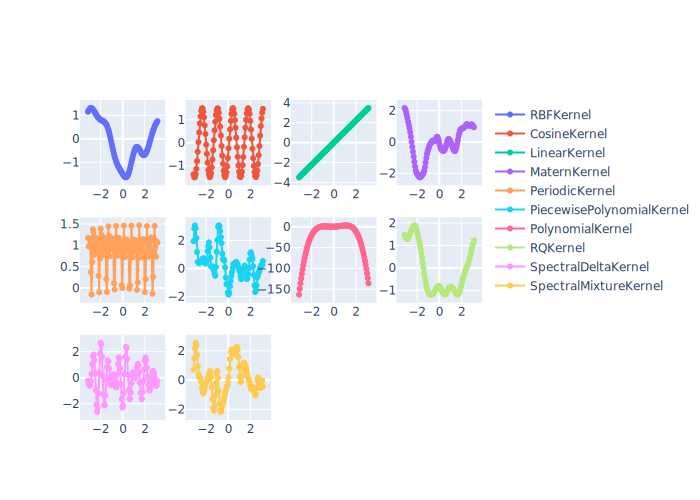

In [6]:
run_vairous_kernels(X, SAMPLE_KERNELS)

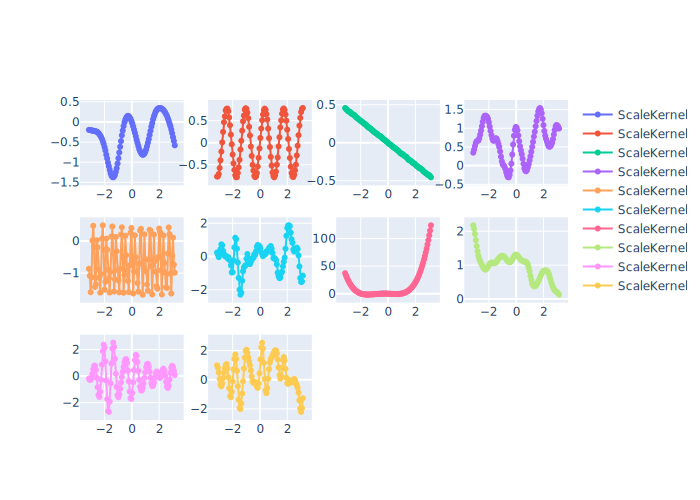

In [7]:
run_vairous_kernels(X, SAMPLE_KERNELS, True)

In [8]:
def run_vairous_kernels_with_diag(x, sample_kernels):
    fig = make_subplots(rows=3, cols=4)
    for idx, k in enumerate(sample_kernels):           
        row = idx // 4 + 1
        col = idx % 4 + 1    
        plot_kernel(fig, x, k, row, col, diag=True)
    fig.show()

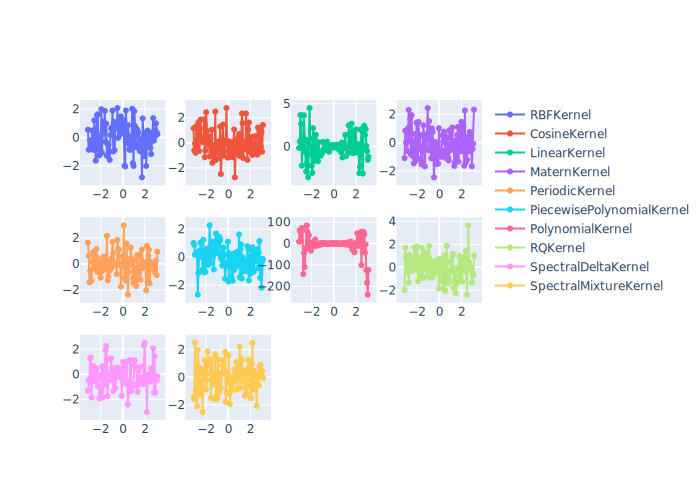

In [9]:
run_vairous_kernels_with_diag(X, SAMPLE_KERNELS)

In [10]:
def run_vairous_kernels_covariance(x, sample_kernels):
    subplot_titles = [k.__class__.__name__ for k in sample_kernels]
    fig = make_subplots(rows=3, cols=4, subplot_titles=subplot_titles)
    for idx, k in enumerate(sample_kernels):    
        row = idx // 4 + 1
        col = idx % 4 + 1
        fig = plot_covariance(fig, X, k, row, col)
    fig.show()


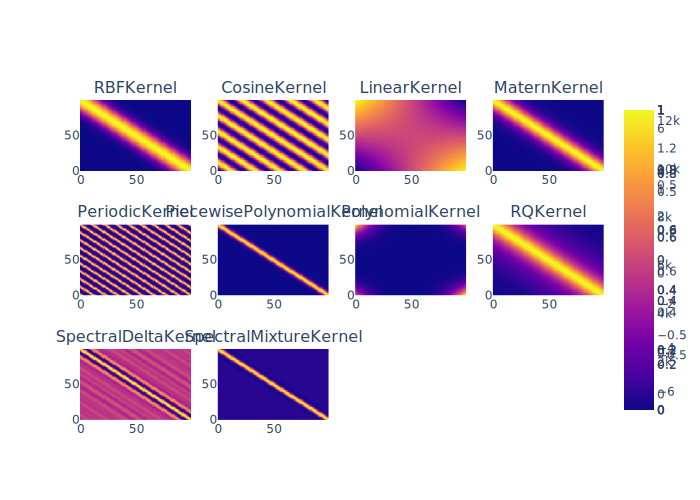

In [11]:
run_vairous_kernels_covariance(X, SAMPLE_KERNELS)

In [12]:
def model_train(X, Y, likelihood, kernel):
    gp = botorch.models.SingleTaskGP(X, Y, likelihood, kernel)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
    botorch.fit_gpytorch_mll(mll)
    return gp

In [13]:
def train_bayes_opt(sample_kernels, num_train_points=3, func=torch.sin, min_max_const=math.pi):
    subplot_titles = [k.__class__.__name__ for k in sample_kernels]
    fig = make_subplots(rows=3, cols=4, subplot_titles=subplot_titles)
    train_x = min_max_const * 2 * (torch.rand(num_train_points)-0.5).view(-1, 1).double()
    test_x = torch.linspace(-min_max_const, min_max_const, 100).view(-1, 1).double()
    train_y = func(train_x)
    for idx, k in enumerate(SAMPLE_KERNELS):
        row = idx // 4 + 1
        col = idx % 4 + 1
        gp = model_train(train_x, train_y, SAMPLE_LINELIHOODS[0](), k)
        y_mean = gp(test_x).mean.detach().numpy()
        y_stddev = gp(test_x).stddev.detach().numpy()
        fig.add_trace(go.Scatter(x=test_x.view(-1), y=y_mean, mode="lines", name="Test", error_y=dict(type='data', array=y_stddev, 
                      color='rgba(135, 206, 250, 0.5)'), line=dict(color='blue')), row=row, col=col)
        fig.add_trace(go.Scatter(x=test_x.view(-1), y=func(test_x.view(-1)), mode="lines", name="True",
                      line=dict(color='red')), row=row, col=col)
        fig.add_trace(go.Scatter(x=train_x.view(-1), y=train_y.view(-1), mode="markers", name="Observed", marker=dict(color="green")), row=row, col=col)
    fig.show()

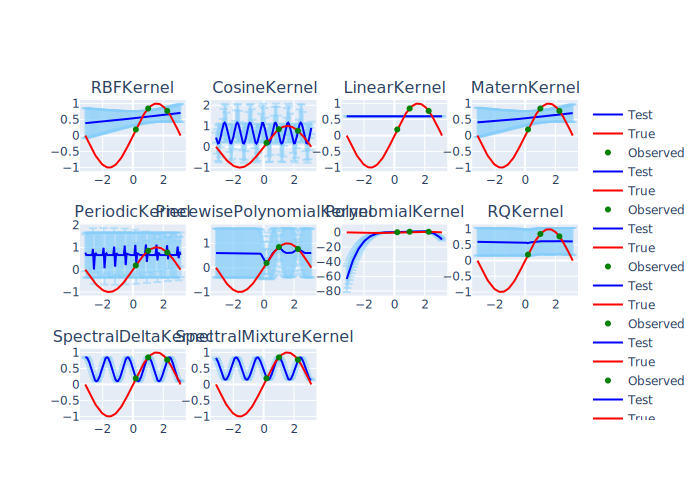

In [14]:
train_bayes_opt(SAMPLE_KERNELS, 3)

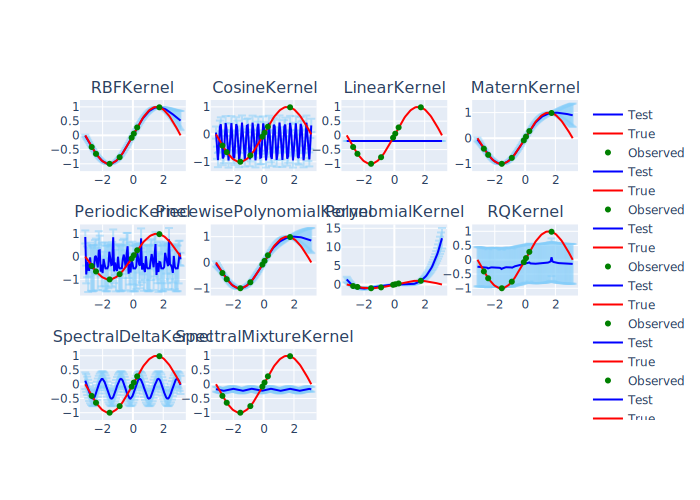

In [15]:
train_bayes_opt(SAMPLE_KERNELS, 8)

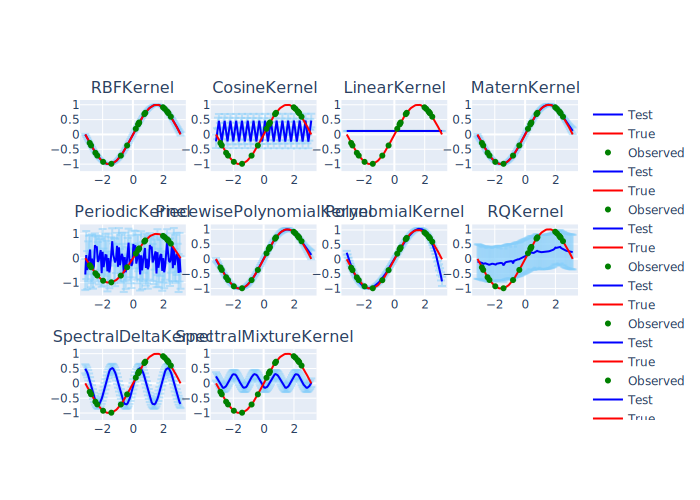

In [16]:
train_bayes_opt(SAMPLE_KERNELS, 20)

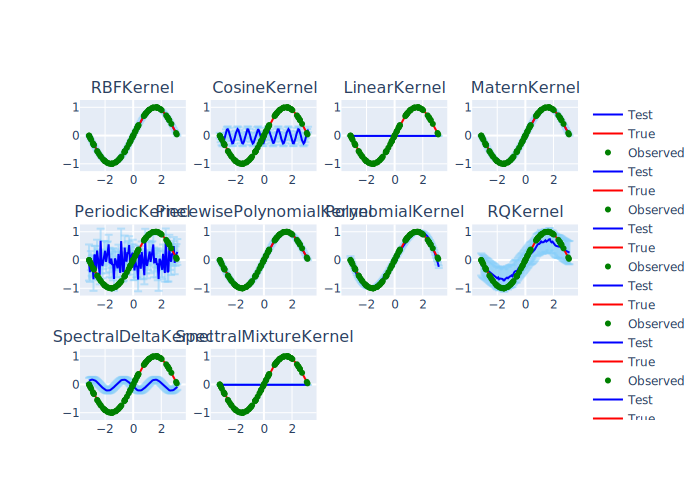

In [17]:
train_bayes_opt(SAMPLE_KERNELS, 100)

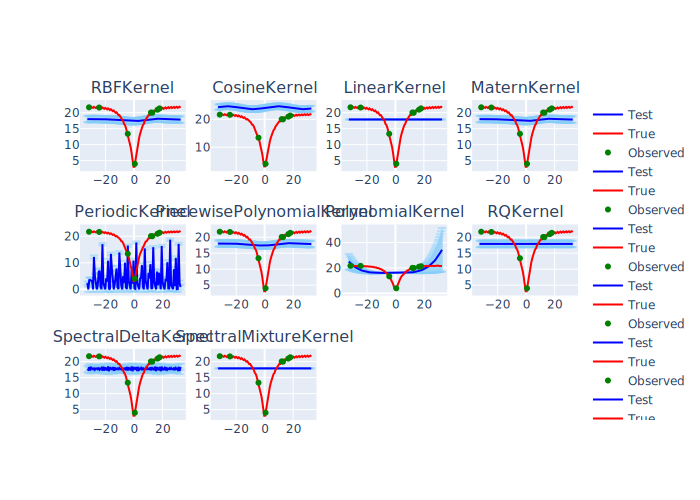

In [19]:
def ackley_1d(x):
    return -20 * torch.exp(-0.2* torch.sqrt(x**2)) - torch.exp(-0.2 * torch.cos(math.pi * x)) + 20 + math.exp(1)

train_bayes_opt(SAMPLE_KERNELS, 8, ackley_1d, 32.7)

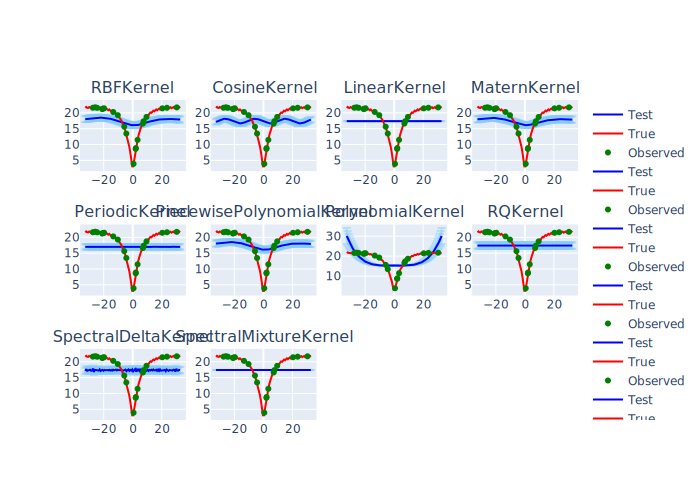

In [20]:
train_bayes_opt(SAMPLE_KERNELS, 20, ackley_1d, 32.7)

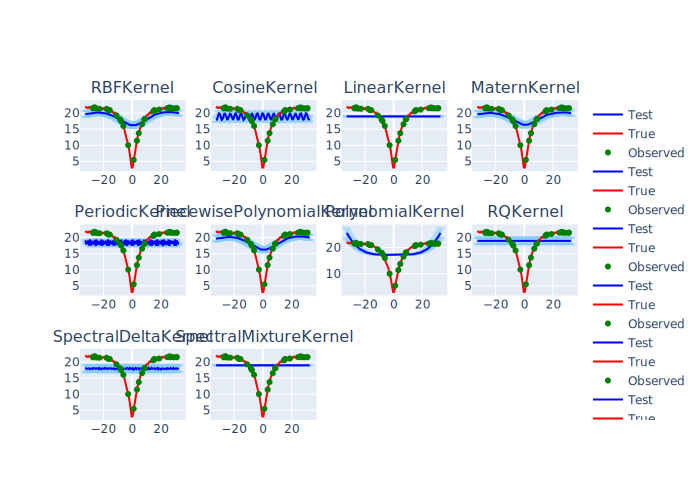

In [21]:
train_bayes_opt(SAMPLE_KERNELS, 30, ackley_1d, 32.7)

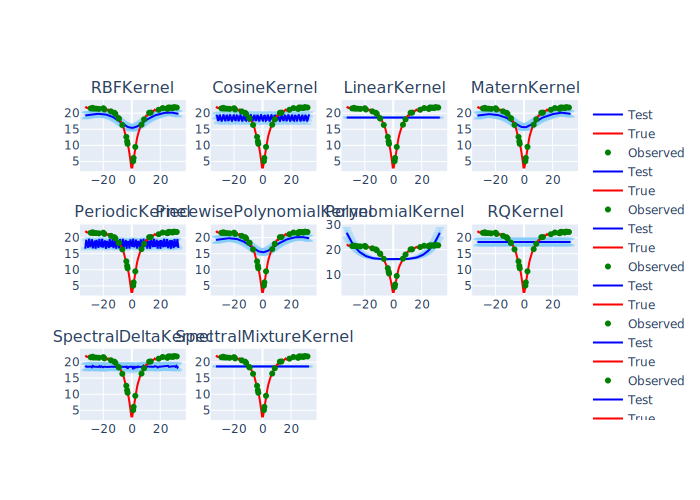

In [23]:
train_bayes_opt(SAMPLE_KERNELS, 35, ackley_1d, 32.7)

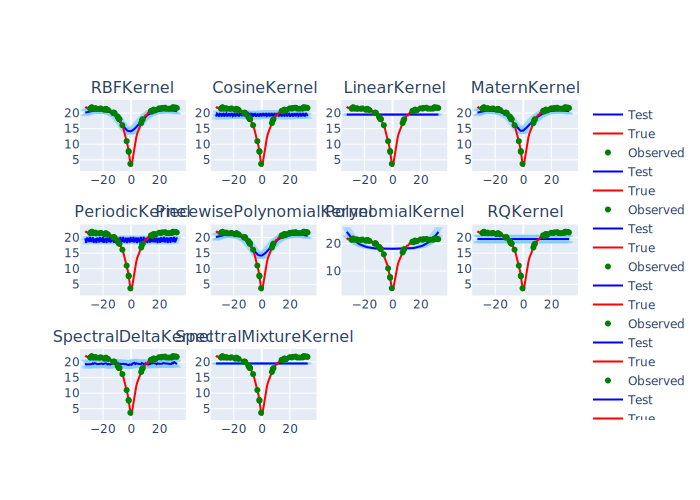

In [24]:
train_bayes_opt(SAMPLE_KERNELS, 50, ackley_1d, 32.7)

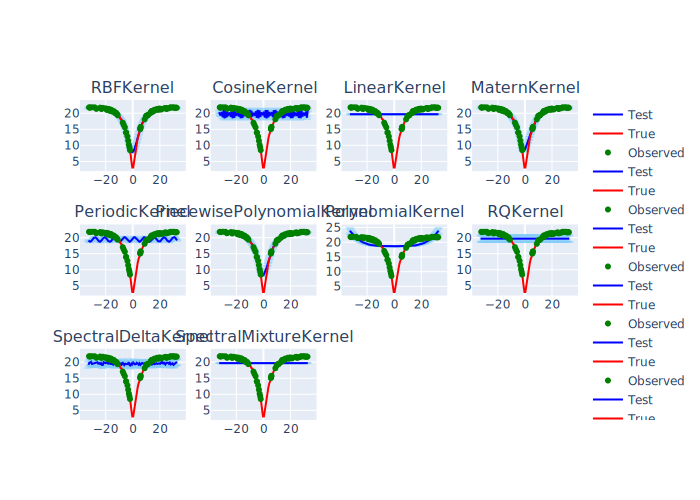

In [28]:
train_bayes_opt(SAMPLE_KERNELS, 80, ackley_1d, 32.7)

In [29]:
def rastrigin(x):
    return 10 + x**2 - 10 * torch.cos(2 * math.pi * x)

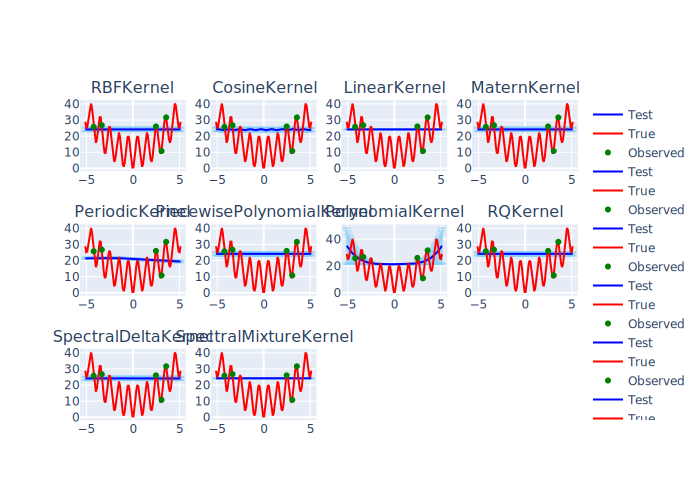

In [30]:
train_bayes_opt(SAMPLE_KERNELS, 5, rastrigin, 5.12)

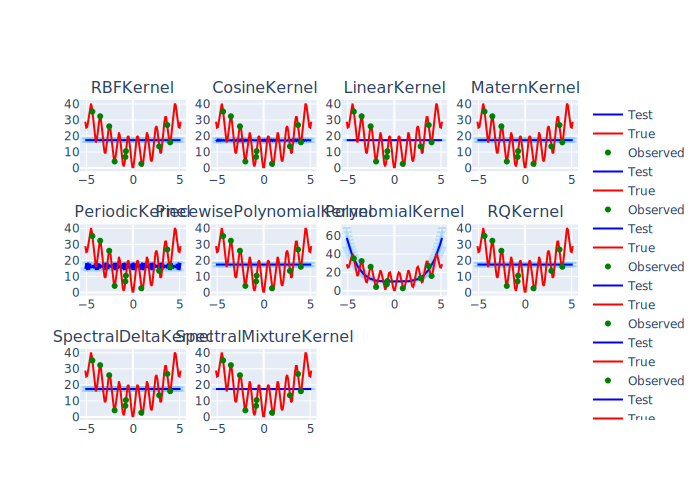

In [31]:
train_bayes_opt(SAMPLE_KERNELS, 10, rastrigin, 5.12)

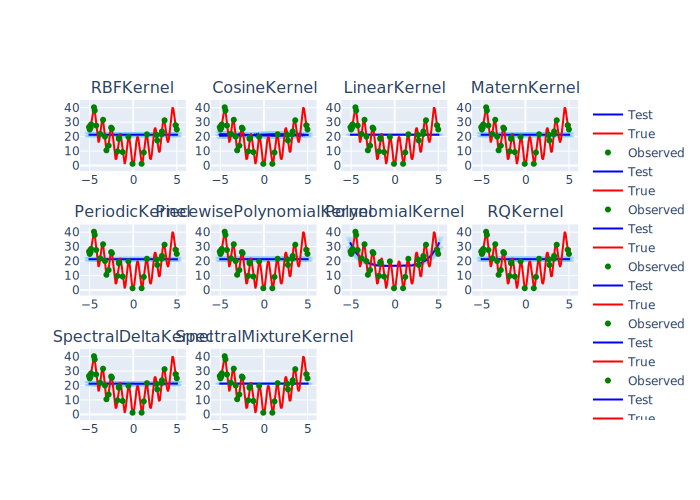

In [32]:
train_bayes_opt(SAMPLE_KERNELS, 30, rastrigin, 5.12)

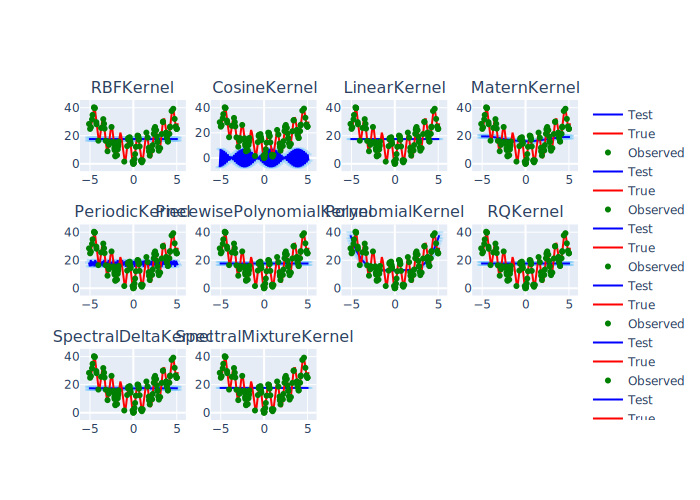

In [34]:
train_bayes_opt(SAMPLE_KERNELS, 100, rastrigin, 5.12)

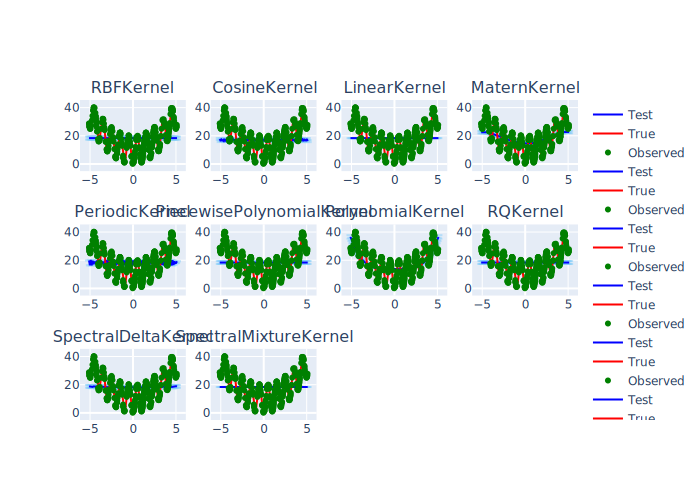

In [35]:
train_bayes_opt(SAMPLE_KERNELS, 300, rastrigin, 5.12)